In [19]:

import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import cv2
from skimage.segmentation import find_boundaries
import os
import fnmatch
from PIL import Image

def load_and_resize_image(image_path):
    # Load image
    img = cv2.imread(image_path)
    #img_resized = cv2.resize(img, (512, 512))
    img_resized_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to uint8 ndarray
    img_resized_uint8 = img_resized_rgb.astype('uint8')
    
    return img_resized_uint8


def extract_features(image, segments):
    features = []
    for segment_label in np.unique(segments):
        segment_mask = segments == segment_label
        segment_pixels = image[segment_mask]
        mean_intensity = np.mean(segment_pixels)
        std_intensity = np.std(segment_pixels)
        area = np.sum(segment_mask)
        features.append([mean_intensity, std_intensity, area])
    return np.array(features)

def automated_labeling(features):
    print(features.shape)
    labels = []
    for feature in features:
        mean_intensity, std_intensity, _ = feature
        if mean_intensity > 0.65:  # fully colored
            labels.append(1)
        elif mean_intensity < 0.3:  # fully black
            labels.append(-1)
        else:
            labels.append(0)  # Middle
    return np.array(labels)

def slic_1(path):
    ##############
    image_array = load_and_resize_image(path)
    img = img_as_float(load_and_resize_image(path))
    #img = img_as_float(image[::2, ::2])
    #segments_fz = felzenszwalb(img, scale=50, sigma=0.4, min_size=20)
    segments_slic = slic(img, n_segments=1250, compactness=10, sigma=1, start_label=1)
    #segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    #gradient = sobel(rgb2gray(img))
    #segments_watershed = watershed(gradient, markers=350, compactness=0.001)
    segments=segments_slic
    #print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
    print(f'number of segments: {len(np.unique(segments))}')
    #print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
    #print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    features = extract_features(img, segments)
    segments_labels = automated_labeling(features)
    mask_1 = np.isin(segments, np.unique(segments)[segments_labels == 1])
    mask_0 = np.isin(segments, np.unique(segments)[segments_labels == 0])

    # Outline boundaries
    boundaries_1 = find_boundaries(mask_1, mode='inner')
    boundaries_0 = find_boundaries(mask_0, mode='inner')

    # Color boundaries
    image=np.copy(img)
    image[boundaries_1] = [0, 0, 1]  # blue for near white
    image[boundaries_0] = [0, 1, 0] #green for greyish-black
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(mark_boundaries(img, segments))
    axes[0].set_title('SLIC Segmentation')
    axes[0].axis('off')

    axes[1].imshow(image)
    axes[1].set_title('Segmented Image with Boundaries')
    axes[1].axis('off')

    plt.show()
    
    
#path=r"C:\Users\Ashwin\Downloads\10127_1554_0159.png"

number of segments: 1255
(1255, 3)


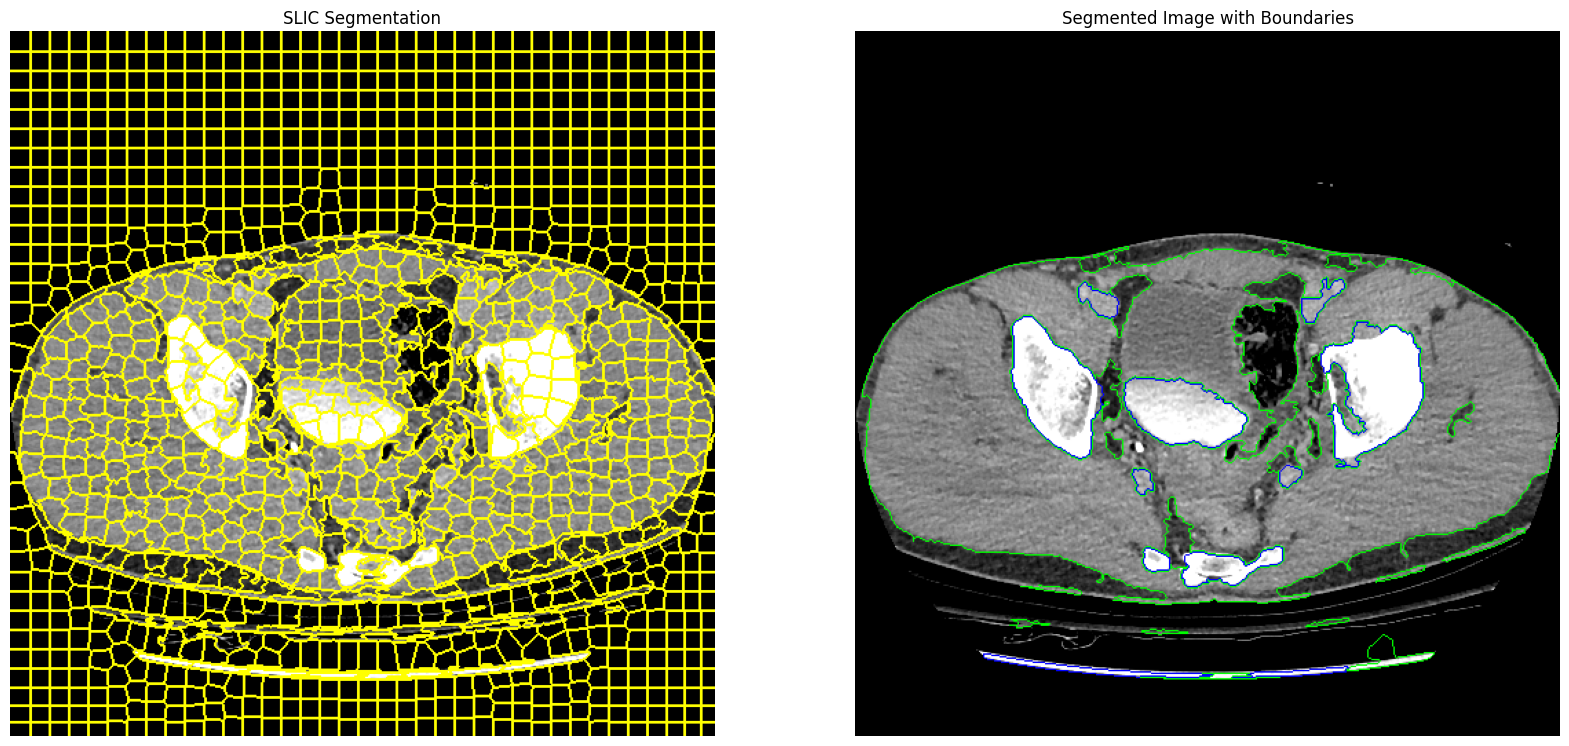

number of segments: 1245
(1245, 3)


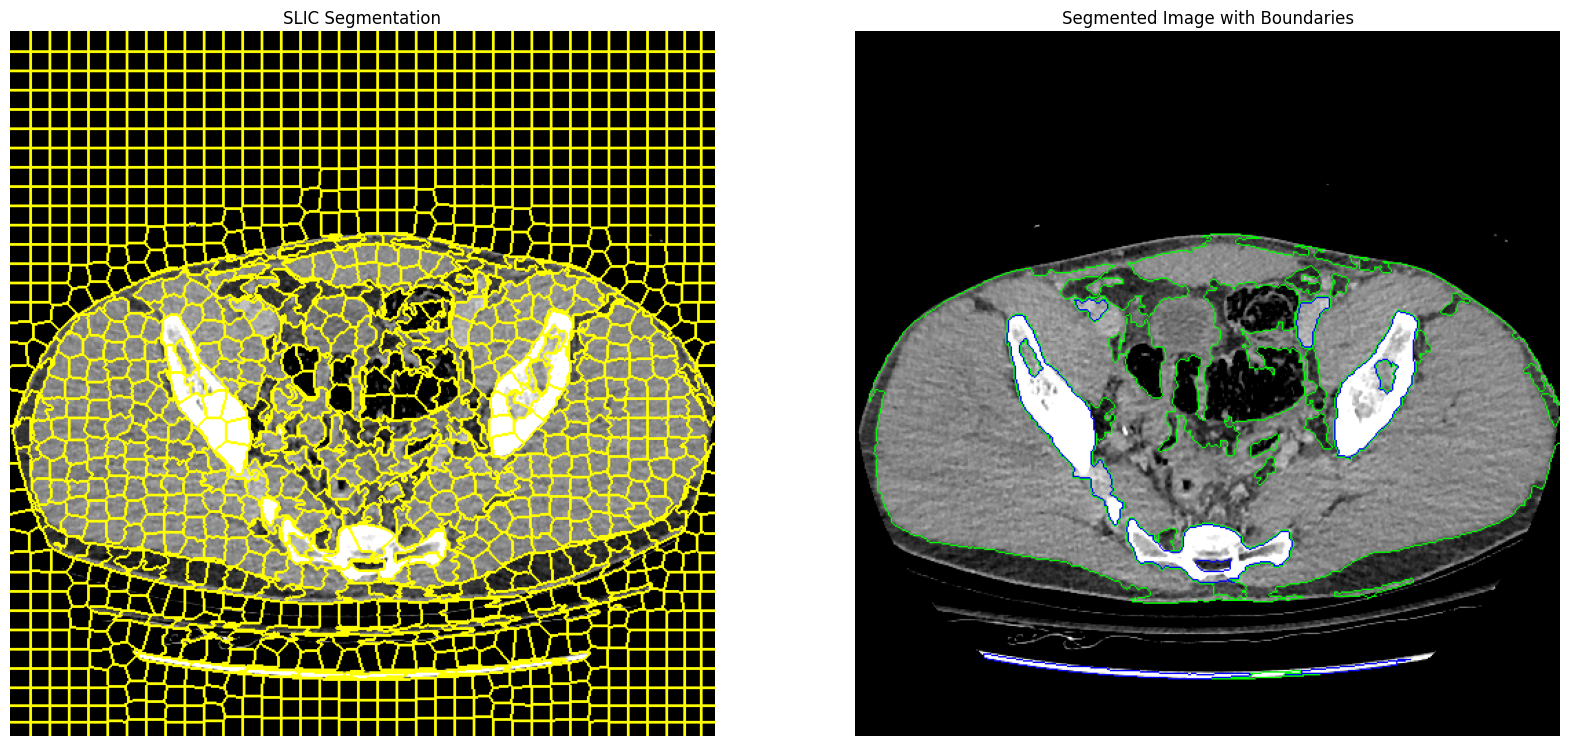

number of segments: 1230
(1230, 3)


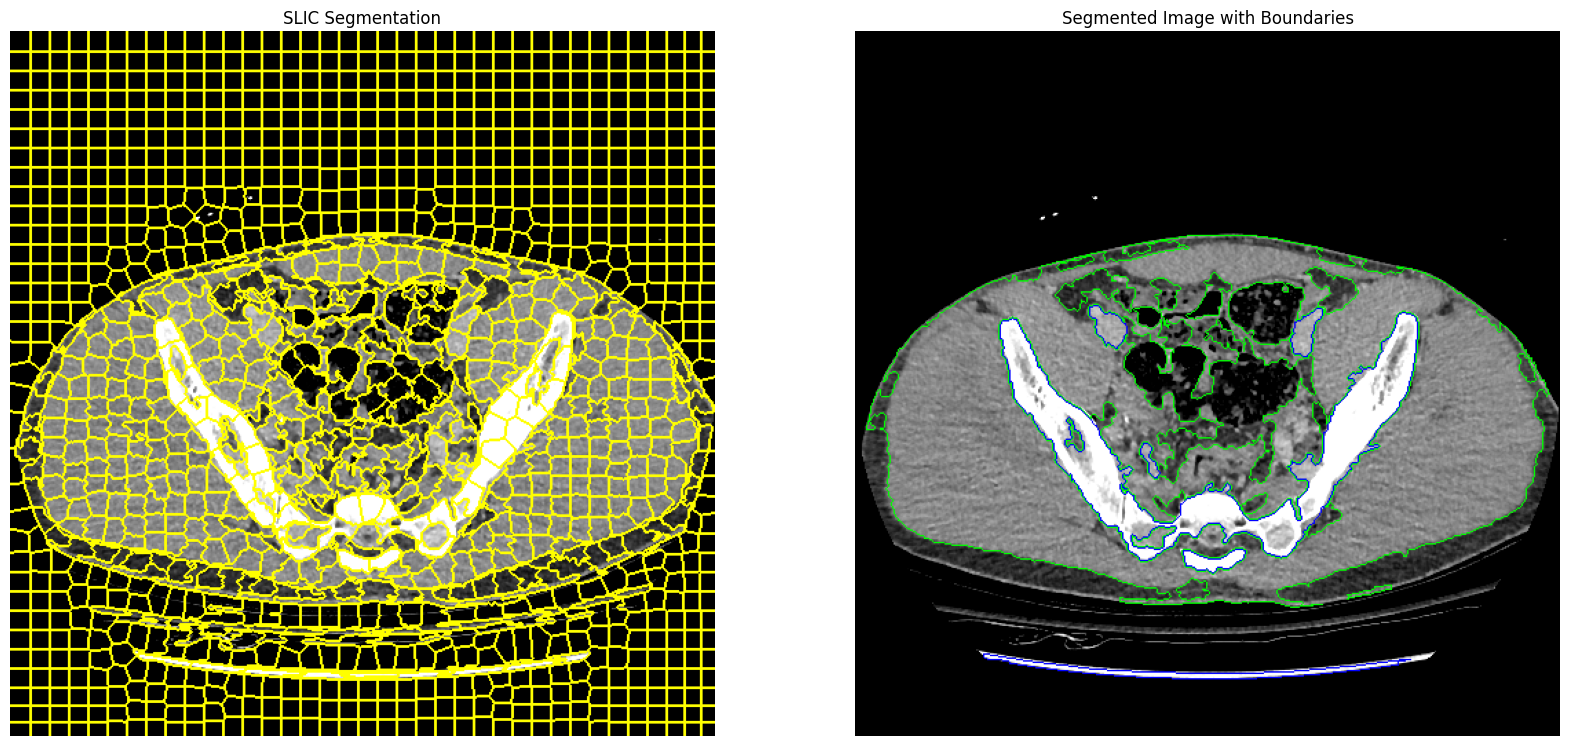

number of segments: 1234
(1234, 3)


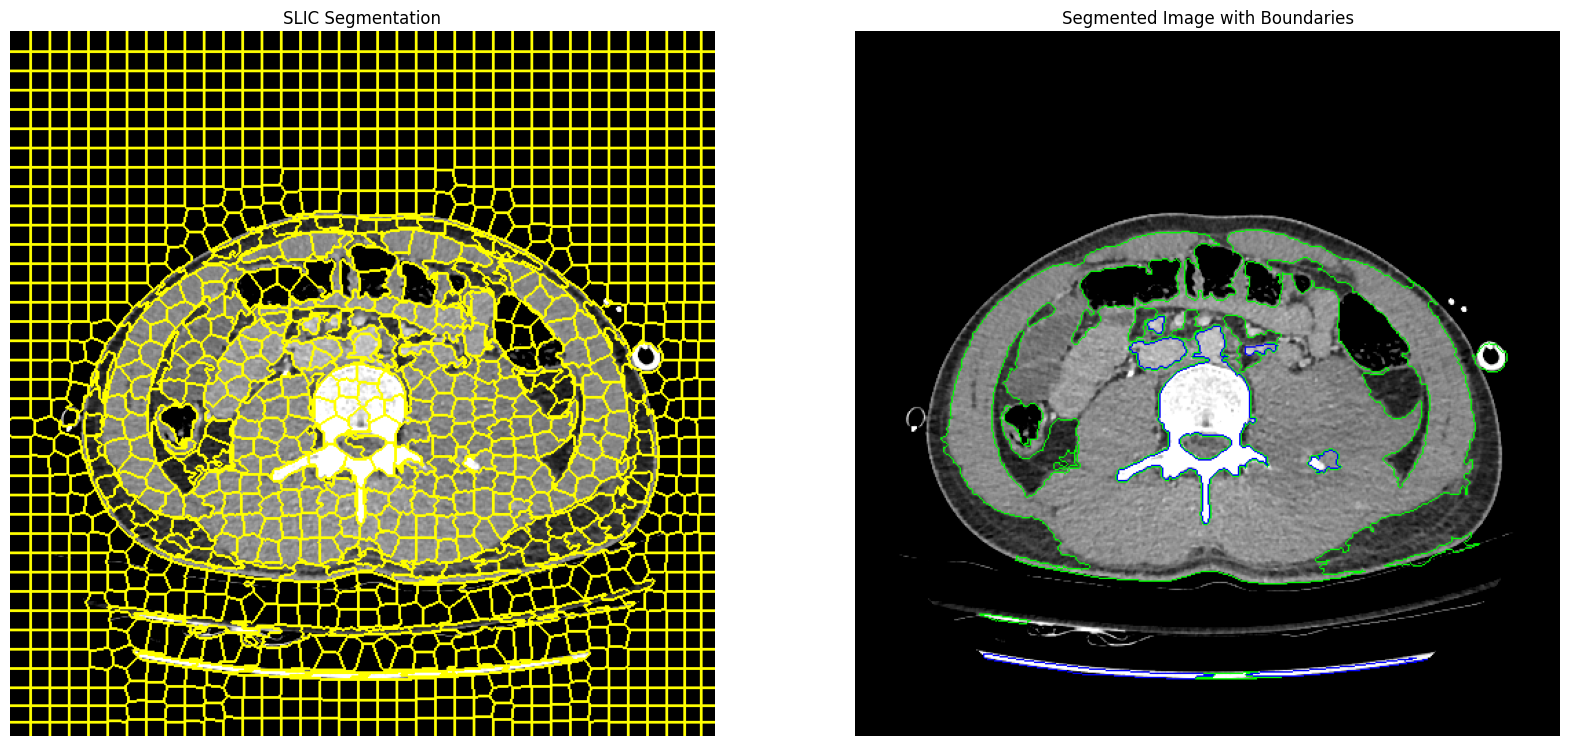

In [20]:


def find_images(root_directory,num):
    if not isinstance(root_directory, (str, bytes, os.PathLike)):
        raise TypeError("Expected str, bytes or os.PathLike object, not {}".format(type(root_directory).__name__))
    
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif', '*.tiff']
    count=0
    for root, dirs, files in os.walk(root_directory):
        for extension in image_extensions:
            for filename in fnmatch.filter(files, extension):
                if(count>num):
                    return
                count+=1
                yield os.path.join(root, filename)
    return



root_directory = r'D:\dataset\dataset\archive'  # hard disk
if isinstance(root_directory, str):
    for image_path in find_images(root_directory,3):
        slic_1(image_path)
else:
    print(f"Invalid root_directory: {root_directory}. Must be a string.")